# Statictics Fundamentals

## Fitting distributions to get parameters

### Fitting normal distribution on solar cell efficiency data

In [1]:
!wget -q --show-progress https://github.com/PacktPublishing/Practical-Data-Science-with-Python/raw/main/Chapter8/data/solar_cell_efficiencies.csv

solar_cell_efficien 100%[===================>]   3.36M  --.-KB/s    in 0.08s   


In [1]:
import pandas as pd

df = pd.read_csv('solar_cell_efficiencies.csv')
df.describe()

,efficiency
count,187196.000000
mean,14.181805
std,0.488751
min,9.691218
25%,13.932445
50%,14.205567
75%,14.482341
max,17.578530


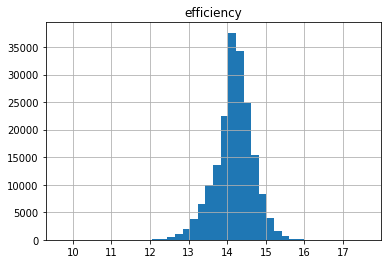

In [2]:
df.hist(bins=40);

In [3]:
df['efficiency'].skew()

-0.3859213025332234

In [4]:
df['efficiency'].kurt()

1.11789277391934

In [6]:
import scipy.stats

scipy.stats.norm.fit(df['efficiency'])

(14.181805365742568, 0.4887500401256815)

### Fitting weibull on MISO wind data

In [7]:
!wget -q --show-progress https://github.com/PacktPublishing/Practical-Data-Science-with-Python/raw/main/Chapter8/test_your_knowledge/data/miso_wind_data.csv

miso_wind_data.csv  100%[===================>] 178.49K  --.-KB/s    in 0.02s   


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

In [9]:
df = pd.read_csv('miso_wind_data.csv')
df.head()

,Market Day,Hour Ending,MWh
0,1/1/2020,1,12161.42
1,1/1/2020,2,13090.65
2,1/1/2020,3,13597.16
3,1/1/2020,4,13638.77
4,1/1/2020,5,13320.79


In [10]:
df.describe()

,Hour Ending
count,8784.000000
mean,12.500000
std,6.922581
min,1.000000
25%,6.750000
50%,12.500000
75%,18.250000
max,24.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Market Day   8784 non-null   object
 1   Hour Ending  8784 non-null   int64 
 2   MWh          8784 non-null   object
dtypes: int64(1), object(2)
memory usage: 206.0+ KB


In [12]:
df['MWh'] = df['MWh'].astype('float')

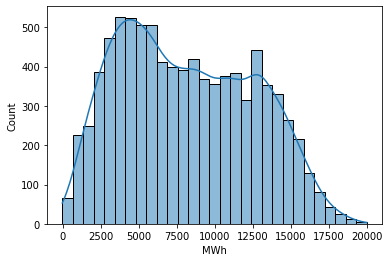

In [14]:
sns.histplot(df['MWh'], kde=True);

Recall from the chapter that Weibull can often be used to model windspeed-related data. The distribution doesn't look perfect here, we should probably break it up by season. But we will still try fitting with a Weibull and see how it compares.

In [15]:
# this gives us c, loc, and scale
wb_fit = weibull_min.fit(df['MWh'])
wb_fit

(0.1041568091512397, -33.580000000000005, 3.3041852511183105)

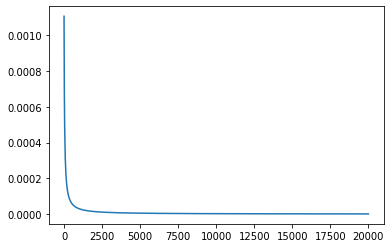

In [17]:
wb = weibull_min(c=wb_fit[0], loc=wb_fit[1], scale=wb_fit[2])
x = np.linspace(0, 20000, 1000)
plt.plot(x, wb.pdf(x))
plt.show()

That doesn't look right at all. We need to give starting values for our parameters so it has a better chance of fitting. Let's play around with the parameters to figure out what it should be closer to. The key here was the scale parameter - it needs to be on the order of the spread of the data.

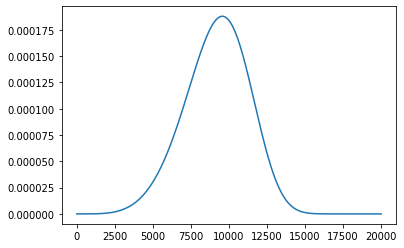

In [18]:
wb = weibull_min(c=5, loc=0, scale=10000)
plt.plot(x, wb.pdf(x))
plt.show()

In [19]:
params = weibull_min.fit(df['MWh'].values, scale=20000)
params

(2.0806616070968973, -448.4293623193927, 9704.828895457018)

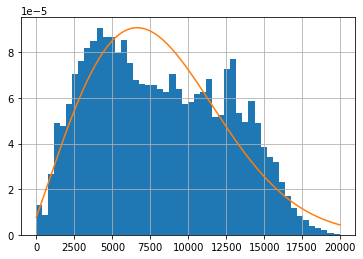

In [20]:
wb = weibull_min(c=params[0], loc=params[1], scale=params[2])
f, ax = plt.subplots()
# the density=1 argument makes the integral of the histogram equal 1, so it's on the same scale as the PDF
df['MWh'].hist(density=1, ax=ax, bins=50)
ax.plot(x, wb.pdf(x))
plt.show()

Hey, not a bad fit! It looks like it is like a bi-modal distribution, composed of two or three Weibulls from the different seasons. We chose the Weibull, again, because it's known to represent this sort of data. Also, we can eyeball the histogram and pick a distribution that seems to fit.

In [21]:
means = []
for i in range(10000):
    sample = np.random.choice(df['MWh'], 1000, replace=True)
    means.append(sample.mean())

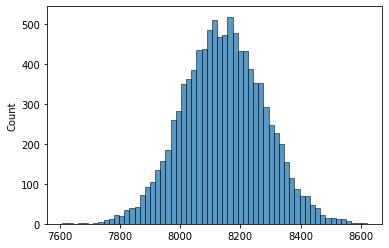

In [22]:
sns.histplot(means)
plt.show()

Yes, looks like it's approaching a normal distribution.

## Statistical Tests

### 1-sample 2-sided T-test

In [24]:
import pandas as pd

solar_data = pd.read_csv('solar_cell_efficiencies.csv')

In [25]:
from scipy.stats import ttest_1samp

print(solar_data['efficiency'].mean())
ttest_1samp(solar_data['efficiency'], 14, alternative='two-sided')

14.181805365742541


Ttest_1sampResult(statistic=160.9411176293201, pvalue=0.0)

In [27]:
sample = solar_data['efficiency'].sample(30, random_state=1)
print(sample.mean())
ttest_1samp(sample, 14)

14.100587953561668


Ttest_1sampResult(statistic=1.2215589926015267, pvalue=0.2317121281215101)

When we are considering full sample, p-value is less than significance level ($\alpha$) of 0.05, so we reject the null hypothesis. This means the solar efficiency is more than 14%. On the other hand, we failed to reject the null hypothesis on a sample data of 30 records.

The proper test to use for larger sample sizes is the z-test. This ends up being about the same as a t-test, however. We can use this from the statsmodels package.

In [ ]:
from statsmodels.stats.weightstats import ztest

In [29]:
ztest(solar_data['efficiency'], value=14)

(160.9411176293201, 0.0)

Let's say we want to make sure the average efficiency of our latest batch of solar cells is greater than 14%. The sample we used that was measured from a recent production run is in our solar data we've already loaded. We can formulate our null hypothesis as this: the sample mean is less than or equal to the expected mean of 14%. The alternative hypothesis is then: the sample mean is greater than the expected mean of 14%. We can perform this test with scipy like so:

In [30]:
ttest_1samp(solar_data['efficiency'], 14, alternative='greater')

Ttest_1sampResult(statistic=160.9411176293201, pvalue=0.0)

The alternative argument is set to 'greater', meaning the alternative hypothesis is that the sample mean is greater than the expected mean. Our results show the null hypothesis is rejected, and it looks like our sample mean is greater than 14% with statistical significance.

In [31]:
ttest_1samp(solar_data['efficiency'], 14, alternative='less')

Ttest_1sampResult(statistic=160.9411176293201, pvalue=1.0)

### A/B testing

In [32]:
!wget -q --show-progress https://github.com/PacktPublishing/Practical-Data-Science-with-Python/raw/main/Chapter9/data/ab_sales_data.csv

ab_sales_data.csv   100%[===================>]  39.08K  --.-KB/s    in 0.002s  


Let's say we have a website selling t-shirts and want to experiment with the design to try and drive more sales. We're going to change the layout in a B version of the site and compare our sales rates to the A version.

In [35]:
ab_df = pd.read_csv('ab_sales_data.csv')
ab_df.head()

,a_sale,b_sale
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


We have a column for the A design, and each row is a website visitor. A value of 1 represents a sale, while 0 represents no sale. The B design column is the same, and the samples are not paired up (each sample from A and B is individual and independent). We can look at the mean sales rates easily:

In [36]:
ab_df.mean()

a_sale    0.0474
b_sale    0.0544
dtype: float64

This shows us B has a slightly higher sales rate. To test if B is really better than A, we can first try a two-sample, two-sided t-test. The null hypothesis is that the means of the two groups are the same; the alternative is that they are not the same (for a two-sided test).

In [37]:
ztest(ab_df['a_sale'], ab_df['b_sale'])

(-2.252171812056176, 0.02431141659730297)

Remember that the first value is the z-statistic, and the second value in the tuple is the p-value. In this case, it looks like there is a significant difference in the means, since the p-value of 0.024 is less than our significance threshold of 0.05. We already know from examination that the B sales rate was a little higher, so it appears the B design is better.

To be a little more precise, we can also specify the direction of the test. With statsmodels, the options for the alternative argument are two-sided, larger, and smaller. Specifying larger means the alternative hypothesis is that A's mean is larger than B's. The null hypothesis in that case is that A's mean is less than or equal to B's mean. We'll use smaller to carry out our one-sided z-test to see if B's average sales value is greater than A's:

In [38]:
ztest(ab_df['a_sale'], ab_df['b_sale'], alternative='smaller')

(-2.252171812056176, 0.012155708298651485)

In [39]:
ztest(ab_df['a_sale'], ab_df['b_sale'], value=-0.01, alternative='smaller')

(0.9652164908812186, 0.8327818056014687)

In [40]:
ztest(ab_df['b_sale'], ab_df['a_sale'], value=0.01, alternative='larger')

(-0.9652164908812186, 0.8327818056014687)

### Bootstrap A/B

In [42]:
!pip install -q bootstrapped

Bootstrapping is another method for A/B testing. With this, we can use sampling with replacement (bootstrapping) to calculate many means of our A and B datasets, then get the confidence intervals of the difference in mean values between A and B. If the confidence interval for the difference in means doesn't pass through 0, we can say with a certain percent confidence that the means are different. For example, we can use the bootstrapped package (which you will need to install with pip install bootstrapped) to do this:

In [43]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

bs.bootstrap_ab(test=ab_df['b_sale'].values,
                ctrl=ab_df['a_sale'].values,
                stat_func=bs_stats.mean,
                compare_func=bs_compare.difference,
                alpha=0.05)

0.006999999999999999    (0.0008000000000000021, 0.013199999999999996)

The values are small, but we can see the 95% confidence interval doesn't quite pass through 0, so we can say with 95% confidence B is better than A. However, it could be that B is only better than A by 0.0008 in absolute value, which wouldn't be much of an improvement on A.

### Testing between several groups with ANOVA

Testing one or two samples is useful in many situations, but we can also find ourselves needing to test the means between several groups. We can use multiple t-tests with the Bonferroni correction as one method, but another way is to use ANOVA and post hoc tests.

Let's say we want to test more than one design at a time and compare them all to see which is best: A, B, and C designs. For comparing the means of three or more groups, we can use an ANOVA test. There is also a way to compare several groups with t-tests using what's called the Bonferroni correction; this is available in the scikit_posthocs.posthoc_ttest() function from the scikit-posthocs package (you will need to install this package with conda or pip). This would tell us the difference between all the pairs from our groups of data – we will come back to other ways to do this shortly.

However, ANOVA can be first used to see if there is any difference between any of the groups. Instead of a t-test, it uses an F-test. Again, this method provides a p-value, which we compare to a significant value we choose (usually 0.05).

In [44]:
!wget -q --show-progress https://github.com/PacktPublishing/Practical-Data-Science-with-Python/raw/main/Chapter9/data/abc_sales_data.csv

abc_sales_data.csv  100%[===================>]   6.11K  --.-KB/s    in 0s      


Because one assumption for ANOVA is that the data comes from normal distributions, we are using data from binomial distributions. This is chunks of 100 website visitors, with a count of how many visitors made a purchase.

Each row is a number between 0 and 100. As we learned in the previous chapter, sampling data from distributions many times tends toward a normal distribution, so if we structure our data in this way, we can approach a normal distribution instead of a binomial distribution like with our other set of A/B sales data.

In this case, a binomial distribution is based on Bernoulli trials (like coin flips), and a collection of binomial distribution samples tends toward a normal distribution. We can load the data with pandas, then conduct an ANOVA test:

In [45]:
from scipy.stats import f_oneway

abc_df = pd.read_csv('abc_sales_data.csv')
abc_df.head()

,a_sale,b_sale,c_sale
0,4,5,6
1,9,10,11
2,6,7,8
3,5,6,7
4,3,3,4


In [46]:
f_oneway(abc_df['a_sale'], abc_df['b_sale'], abc_df['c_sale'])

F_onewayResult(statistic=186.87190542706728, pvalue=3.2965090243696937e-77)

In [47]:
abc_df.mean()

a_sale    4.926
b_sale    5.534
c_sale    6.903
dtype: float64

Here, we provide as many datasets as we want to our f_oneway() function, which performs an ANOVA test. We get an F-statistic and p-value. As usual, we compare the p-value to our significance level to determine if we can reject the null hypothesis. The null hypothesis here is that the means are all the same; the alternative is that the means are different. Since p < 0.05, we can reject the null hypothesis, and our test shows the means to be different. Looking at the means with abc_df.mean(), we can see they are 4.9, 5.5, and 6.9 for A, B, and C, which look quite different. However, it would be nice to know which differences between the groups are significant. For this, we can use a post hoc test.

There are several post hoc tests, but we will use one common post hoc test: the Tukey test. This is named after John Tukey, the legendary statistician who created boxplots and pioneered EDA. Different ANOVA post hoc tests have different subtleties that make them useful in different situations, but Tukey is a decent general test to use as a default.

In [49]:
!pip install -q scikit_posthocs

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [50]:
from scikit_posthocs import posthoc_tukey

melted_abc = abc_df.melt(var_name='groups', value_name='values')
melted_abc.head()

,groups,values
0,a_sale,4
1,a_sale,9
2,a_sale,6
3,a_sale,5
4,a_sale,3


In [51]:
posthoc_tukey(melted_abc, group_col='groups', val_col='values')

,a_sale,b_sale,c_sale
a_sale,1.000,0.001,0.001
b_sale,0.001,1.000,0.001
c_sale,0.001,0.001,1.000


These are p-values for the hypothesis we are testing that the means are not different between pairs. Since the p-values are small between all the pairs (0.001, much less than 0.05) we can say the differences between the means of all the groups are significant. It is possible with the test that some differences between groups may be significant while others may not.

### Comparing Winds in different seasons with ANOVA

In [52]:
!wget -q --show-progress https://github.com/PacktPublishing/Practical-Data-Science-with-Python/raw/main/Chapter9/test_your_knowledge/data/miso_wind_data.csv

miso_wind_data.csv. 100%[===================>] 178.49K  --.-KB/s    in 0.02s   


In [53]:
import pandas as pd
from scikit_posthocs import posthoc_tukey

In [54]:
df = pd.read_csv('miso_wind_data.csv')
df.head()

,Market Day,Hour Ending,MWh
0,1/1/2020,1,12161.42
1,1/1/2020,2,13090.65
2,1/1/2020,3,13597.16
3,1/1/2020,4,13638.77
4,1/1/2020,5,13320.79


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Market Day   8784 non-null   object
 1   Hour Ending  8784 non-null   int64 
 2   MWh          8784 non-null   object
dtypes: int64(1), object(2)
memory usage: 206.0+ KB


In [56]:
df['MWh'] = df['MWh'].astype('float')
df['Market Day'] = pd.to_datetime(df['Market Day'])
df.set_index('Market Day', inplace=True)

spring = df['3-1-2020': '5-31-2020'][['MWh']]
summer = df['6-1-2020': '8-31-2020'][['MWh']]
fall = df['9-1-2020': '11-30-2020'][['MWh']]
winter = df['12-1-2020':][['MWh']]

spring.columns = ['spring']
summer.columns = ['summer']
fall.columns = ['fall']
winter.columns = ['winter']

spring.reset_index(inplace=True, drop=True)
summer.reset_index(inplace=True, drop=True)
fall.reset_index(inplace=True, drop=True)
winter.reset_index(inplace=True, drop=True)

tukey_df = pd.concat([spring.iloc[:744], summer.iloc[:744], fall.iloc[:744], winter.iloc[:744]], axis=1)
tukey_df.head()

,spring,summer,fall,winter
0,13207.85,12868.09,5153.18,9500.17
1,12951.70,12018.25,5065.62,9628.47
2,12743.27,11392.95,5118.42,9640.06
3,12761.31,11709.88,5070.59,9163.20
4,12457.18,11582.99,5236.84,8834.51


In [57]:
melted = tukey_df.melt(var_name='groups', value_name='values')
melted.head()

,groups,values
0,spring,13207.85
1,spring,12951.70
2,spring,12743.27
3,spring,12761.31
4,spring,12457.18


In [58]:
posthoc_tukey(melted, group_col='groups', val_col='values')

,spring,summer,fall,winter
spring,1.000000,0.001649,0.900000,0.003585
summer,0.001649,1.000000,0.016828,0.001000
fall,0.900000,0.016828,1.000000,0.001000
winter,0.003585,0.001000,0.001000,1.000000


In [59]:
tukey_df.mean()

spring    8629.941344
summer    7829.922083
fall      8480.562460
winter    9383.298374
dtype: float64

We can see the difference in meanbetween most groups is significant, with winter having the strongest wind power, and the summer the weakest. The only groups to not have a significant different are spring and fall. We can see these two have almost the same MWh value around 8500. We used the Tukey test to test for significant differences between multiple groups.